In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd
import os
from glob import glob
import pickle

#display
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import folium
plt.rcParams["figure.figsize"] = (20,15)
from IPython.display import clear_output
import contextily as cx

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
import src.supportClean as sc

import sys
sys.path.append("../")
import src.supportCharts as sch

# input

In [2]:
PATH = "../data/airbnb_airdna"
EXT = "listings.csv"

In [3]:
df = sc.open_csvs_different_folders(PATH, EXT).reset_index(drop=True)

In [4]:
print(df.shape)
df.head(1)

(82142, 75)


id                        listing_url       scrape_id last_scraped   
0  6369  https://www.airbnb.com/rooms/6369  20220911230855   2022-09-12  \

        source                                      name   
0  city scrape  Rooftop terrace room ,  ensuite bathroom  \

                                         description neighborhood_overview   
0  Excellent connection with the AIRPORT and EXHI...                   NaN  \

                                         picture_url  host_id   
0  https://a0.muscache.com/pictures/683224/4cc318...    13660  \

                                  host_url host_name  host_since   
0  https://www.airbnb.com/users/show/13660     Simon  2009-04-16  \

   host_location                                         host_about   
0  Madrid, Spain  Gay couple, heterofriendly, enjoy having guest...  \

  host_response_time host_response_rate host_acceptance_rate   
0       within a day               100%                  86%  \

  host_is_superhost                                 host_thumbnail_url   
0                 f  https://a0.muscache.com/im/pictures/user/79a63...  \

                                    host_picture_url host_neighbourhood   
0  https://a0.muscache.com/im/pictures/user/79a63...     Hispanoamérica  \

   host_listings_count  host_total_listings_count  host_verifications   
0                  1.0                        1.0  ['email', 'phone']  \

  host_has_profile_pic host_identity_verified neighbourhood   
0                    t                      t           NaN  \

  neighbourhood_cleansed neighbourhood_group_cleansed  latitude  longitude   
0         Hispanoamérica                    Chamartín  40.45724   -3.67688  \

                 property_type     room_type  accommodates  bathrooms   
0  Private room in rental unit  Private room             2        NaN  \

   bathrooms_text  bedrooms  beds   
0  1 private bath       1.0   1.0  \

                                           amenities   price  minimum_nights   
0  ["Coffee maker", "Dishwasher", "Cleaning produ...  $77.00               3  \

   maximum_nights  minimum_minimum_nights  maximum_minimum_nights   
0            1125                     3.0                    21.0  \

   minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm   
0                  1125.0                  1125.0                     5.5  \

   maximum_nights_avg_ntm  calendar_updated has_availability  availability_30   
0                  1125.0               NaN                t                0  \

   availability_60  availability_90  availability_365 calendar_last_scraped   
0               26               56                56            2022-09-12  \

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d   
0                 99                     19                       0  \

  first_review last_review  review_scores_rating  review_scores_accuracy   
0   2010-03-14  2022-07-08                  4.87                     4.9  \

   review_scores_cleanliness  review_scores_checkin   
0                       4.82                   4.75  \

   review_scores_communication  review_scores_location  review_scores_value   
0                         4.85                    4.82                 4.85  \

  license instant_bookable  calculated_host_listings_count   
0     NaN                f                               1  \

   calculated_host_listings_count_entire_homes   
0                                            0  \

   calculated_host_listings_count_private_rooms   
0                                             1  \

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.65

In [5]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# data cleaning

the variables aare used from Airbnb are:
- `'abnb_tot_beds'` -> total numbers of beds available on the area.
<br>according to the area, it might be that some neighbothoods have more airbnb listings than other area. The median value is close to 0.
- `'abnb_tot_hosts_listings'` -> number of listings posted by host.
<br>the mean of the values posted are 38; the median is 3, meaning than there's a big chance that a host has more than one listing.
- `'abnb_tot_price'` -> aggregated price.
<br>mean price of the listings.
- `'abnb_tot_offer'` -> number of offers on the area.
<br>the mean is 5.
- `'abnb_tot_owners'` -> total number of owners in the area
- `'abnb_pk'` ->
- `'abnb_tot_reviews'` -> total number of reviews -> used to estimate the number of visitors.
<br>the mean is 227, the median is 14.
- `'abnb_tot_reviews_per_month'` -> avg of visits per month during the time the ad was listed
<br>the mean and the average are similar to 1.

I will remove the rest from the input in order to match the structure.

In [6]:
df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name','description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about','host_response_time', 'host_response_rate', 'host_acceptance_rate','host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood','host_total_listings_count', 'host_verifications','host_has_profile_pic', 'host_identity_verified', 'neighbourhood','neighbourhood_cleansed', 
       'neighbourhood_group_cleansed','property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'amenities','minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights','maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90','availability_365', 'calendar_last_scraped', 'license', 'instant_bookable'], axis = 1, inplace=True)

# EDA

In [7]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude)).set_crs('epsg:4326')

In [8]:
sch.foliumMap(df)

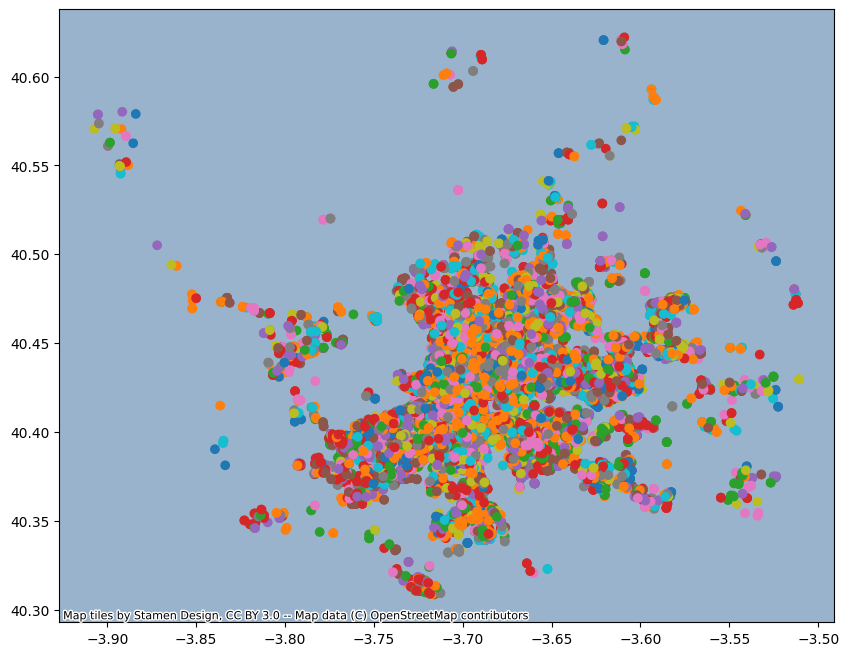

In [9]:
sch.plotMap(gdf, 'price')

In [10]:
sch.analisis_basico(df)

_________________________________

1_Data Structure: (82142, 23)


host_listings_count  latitude  longitude  bedrooms  beds   price   
0                  1.0  40.45724   -3.67688       1.0   1.0  $77.00  \
1                  2.0  40.40381   -3.74130       1.0   1.0  $31.00   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d   
0                 99                     19                       0  \
1                 33                      0                       0   

  first_review last_review  review_scores_rating  review_scores_accuracy   
0   2010-03-14  2022-07-08                  4.87                    4.90  \
1   2014-10-10  2018-07-15                  4.58                    4.72   

   review_scores_cleanliness  review_scores_checkin   
0                       4.82                   4.75  \
1                       4.56                   4.75   

   review_scores_communication  review_scores_location  review_scores_value   
0                         4.85                    4.82                 4.85  \
1                         4.82                    4.21                 4.67   

   calculated_host_listings_count   
0                               1  \
1                               2   

   calculated_host_listings_count_entire_homes   
0                                            0  \
1                                            0   

   calculated_host_listings_count_private_rooms   
0                                             1  \
1                                             2   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0                                            0               0.65  
1                                            0               0.34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82142 entries, 0 to 82141
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_listings_count                           82106 non-null  float64
 1   latitude                                      82142 non-null  float64
 2   longitude                                     82142 non-null  float64
 3   bedrooms                                      76199 non-null  float64
 4   beds                                          80815 non-null  float64
 5   price                                         82142 non-null  object 
 6   number_of_reviews                             82142 non-null  int64  
 7   number_of_reviews_ltm                         82142 non-null  int64  
 8   number_of_reviews_l30d                        82142 non-null  int64  
 9   first_review                                  65160 non-null 

None

_________________________________

2_Duplicated columns:
8608
_________________________________

3_Null values distribution:


host_listings_count latitude longitude bedrooms     beds   price   
nulos                   36        0         0     5943     1327       0  \
dtypes             float64  float64   float64  float64  float64  object   

       number_of_reviews number_of_reviews_ltm number_of_reviews_l30d   
nulos                  0                     0                      0  \
dtypes             int64                 int64                  int64   

       first_review last_review review_scores_rating review_scores_accuracy   
nulos         16982       16982                16982                  17576  \
dtypes       object      object              float64                float64   

       review_scores_cleanliness review_scores_checkin   
nulos                      17568                 17572  \
dtypes                   float64               float64   

       review_scores_communication review_scores_location review_scores_value   
nulos                        17573                  17584               17588  \
dtypes                     float64                float64             float64   

       calculated_host_listings_count   
nulos                               0  \
dtypes                          int64   

       calculated_host_listings_count_entire_homes   
nulos                                            0  \
dtypes                                       int64   

       calculated_host_listings_count_private_rooms   
nulos                                             0  \
dtypes                                        int64   

       calculated_host_listings_count_shared_rooms reviews_per_month  
nulos                                            0             16982  
dtypes                                       int64           float64

_________________________________

4_Numerical variables distribution:


host_listings_count      latitude     longitude      bedrooms   
count         82106.000000  82142.000000  82142.000000  76199.000000  \
mean             21.377402     40.421302     -3.694245      1.470859   
std              88.237712      0.023930      0.029390      0.864983   
min               0.000000     40.308640     -3.907250      1.000000   
25%               1.000000     40.409600     -3.707510      1.000000   
50%               2.000000     40.419770     -3.701110      1.000000   
75%              11.000000     40.430476     -3.686180      2.000000   
max            3404.000000     40.622130     -3.510800     18.000000   

               beds  number_of_reviews  number_of_reviews_ltm   
count  80815.000000       82142.000000           82142.000000  \
mean       1.985003          40.236079              12.453946   
std        1.444752          75.405431              20.441878   
min        1.000000           0.000000               0.000000   
25%        1.000000           1.000000               0.000000   
50%        2.000000           9.000000               3.000000   
75%        2.000000          43.000000              17.000000   
max       40.000000         889.000000             485.000000   

       number_of_reviews_l30d  review_scores_rating  review_scores_accuracy   
count            82142.000000          65160.000000            64566.000000  \
mean                 1.072241              4.593250                4.712989   
std                  1.934783              0.638805                0.439364   
min                  0.000000              0.000000                1.000000   
25%                  0.000000              4.500000                4.640000   
50%                  0.000000              4.750000                4.830000   
75%                  2.000000              4.920000                4.970000   
max                 43.000000              5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin   
count               64574.000000           64570.000000  \
mean                    4.664161               4.763624   
std                     0.468011               0.409074   
min                     1.000000               1.000000   
25%                     4.560000               4.710000   
50%                     4.790000               4.880000   
75%                     4.950000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location   
count                 64569.000000            64558.000000  \
mean                      4.762976                4.775226   
std                       0.432762                0.370199   
min                       1.000000                1.000000   
25%                       4.720000                4.700000   
50%                       4.890000                4.900000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  calculated_host_listings_count   
count         64554.000000                    82142.000000  \
mean              4.578884                       14.391566   
std               0.477703                       34.397187   
min               1.000000                        1.000000   
25%               4.460000                        1.000000   
50%               4.680000                        2.000000   
75%               4.860000                        9.000000   
max               5.000000                      263.000000   

       calculated_host_listings_count_entire_homes   
count                                 82142.000000  \
mean                                     11.981021   
std                                      33.522128   
min                                       0.000000   
25%                                       0.000000   
50%                                       1.000000   
75%                             

_________________________________

5_Categorical variables distribution:


price first_review last_review
count    82142        65160       65160
unique     948         3204        1998
top     $50.00   2019-06-02  2022-11-27
freq      1594          351        1091

numeric variables distribution


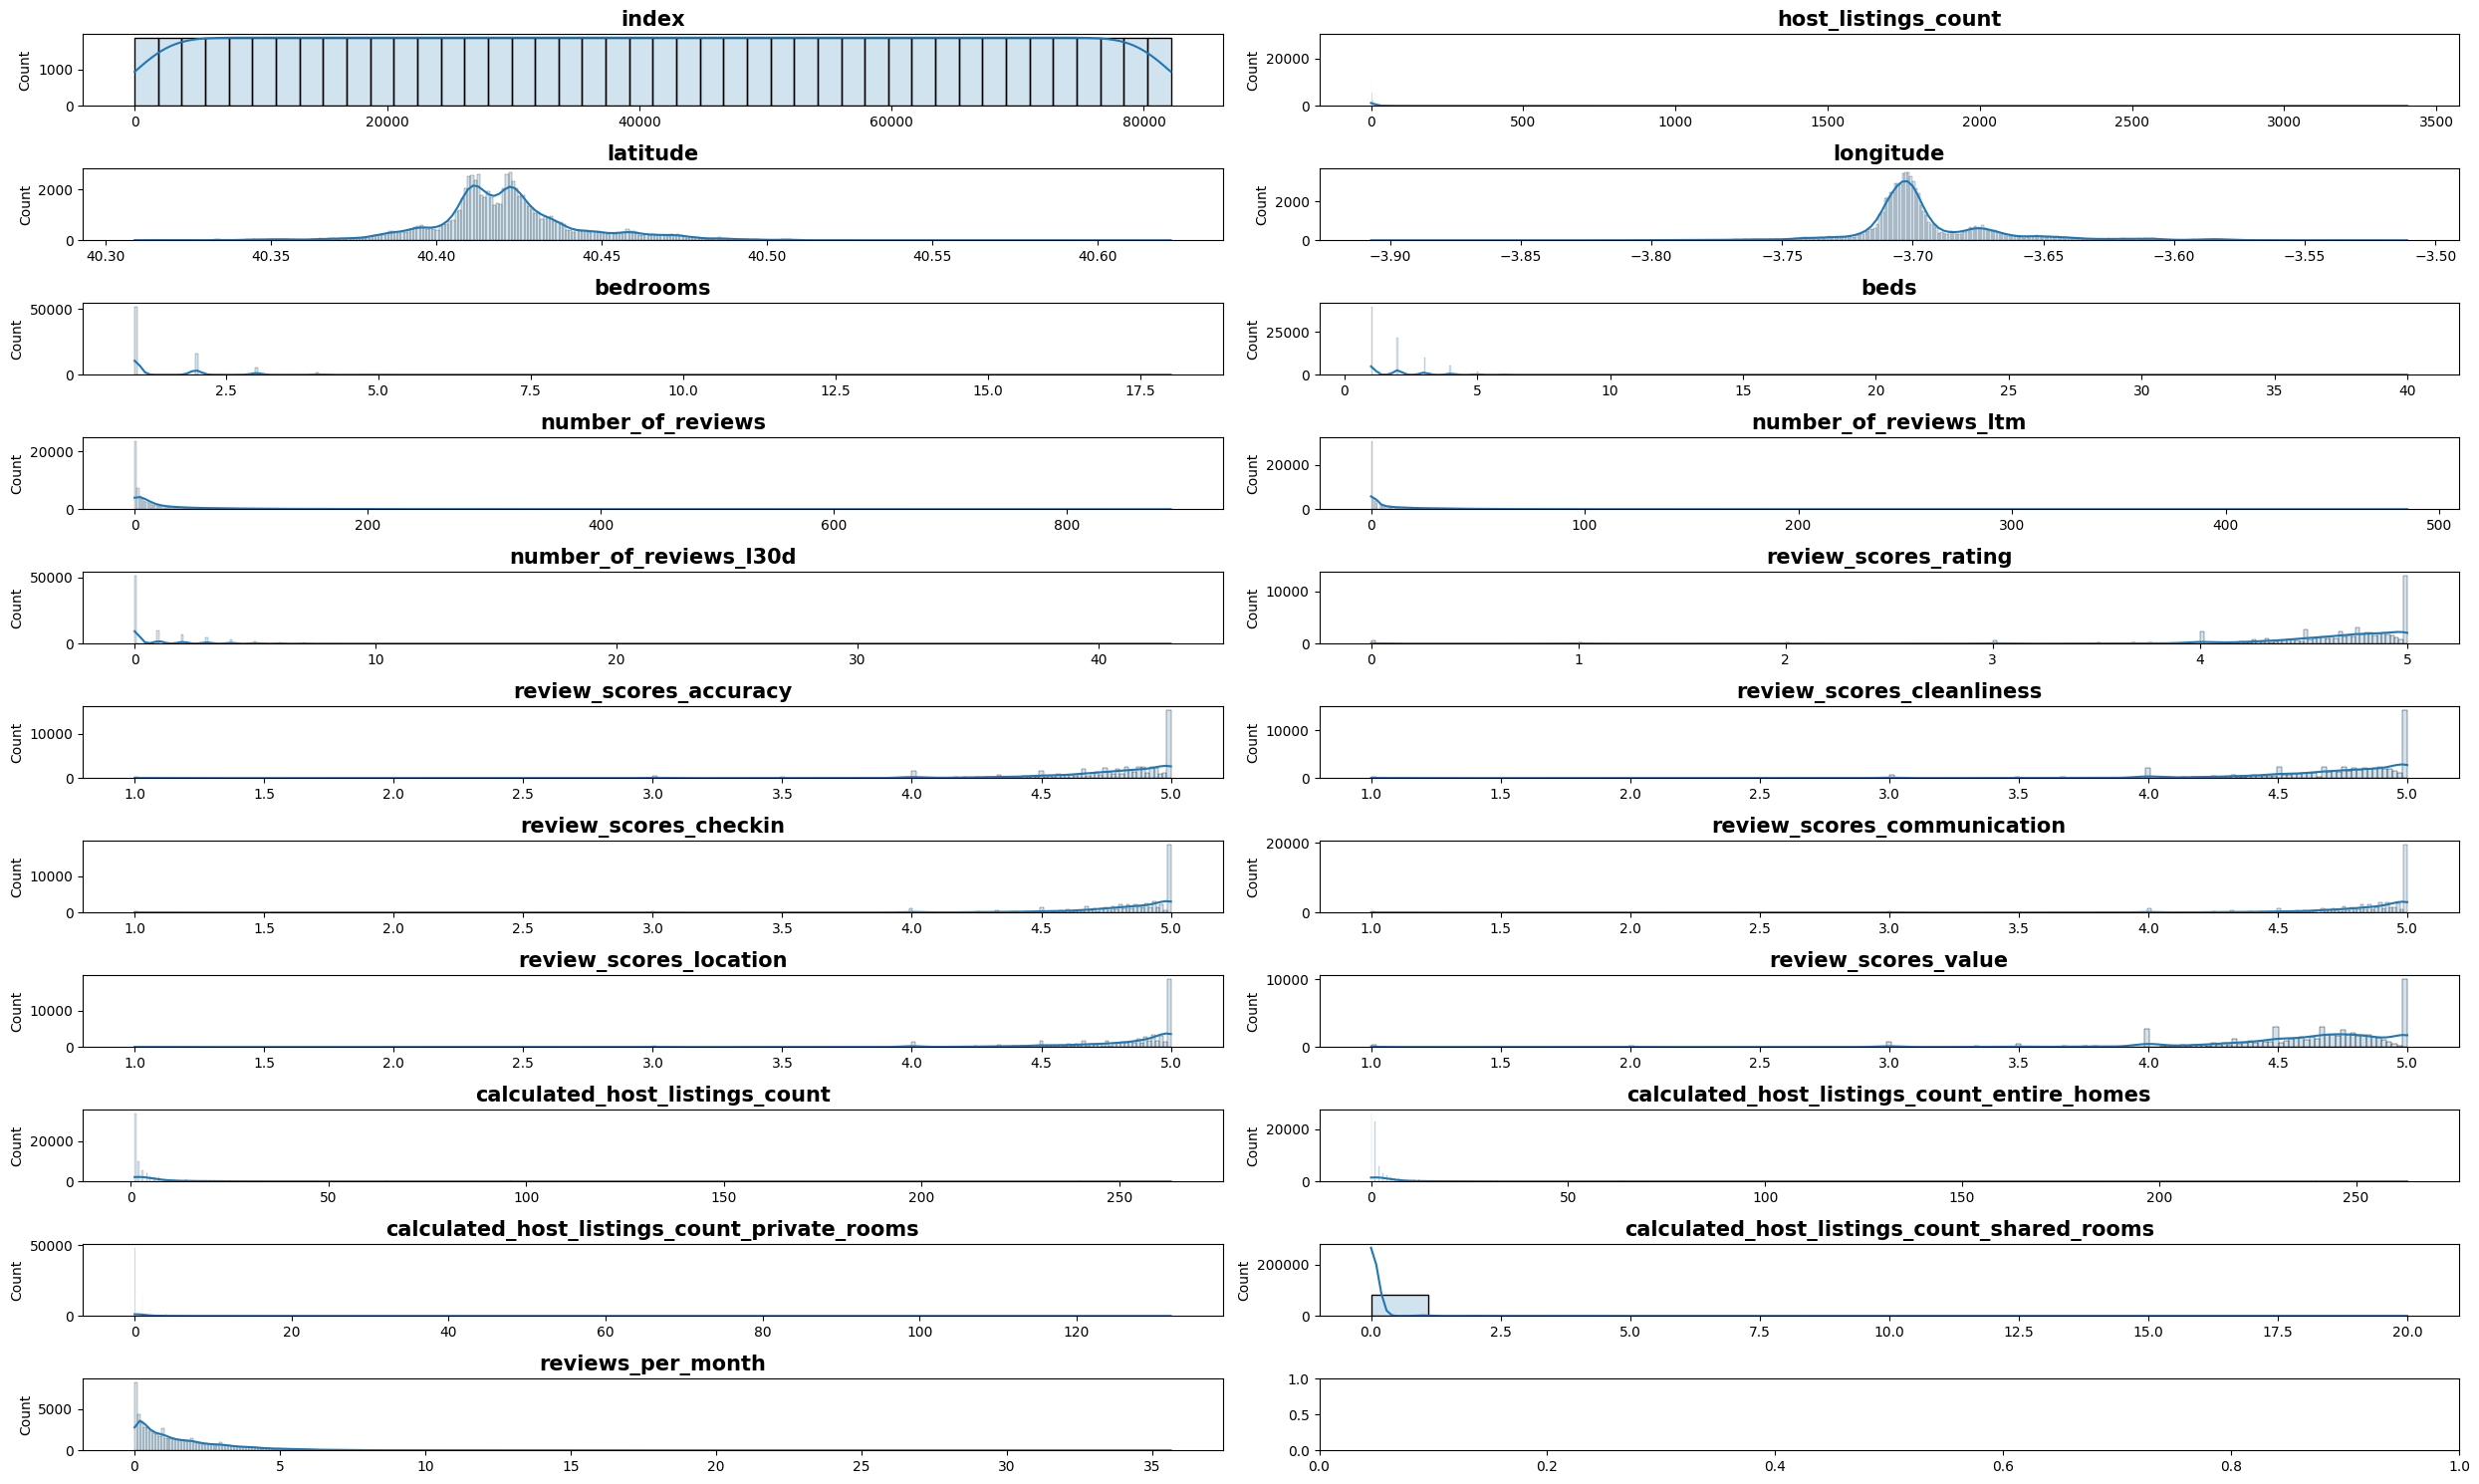

In [11]:
sch.distribucion_numericas(df.reset_index())

numeric variables distribution -> outliers


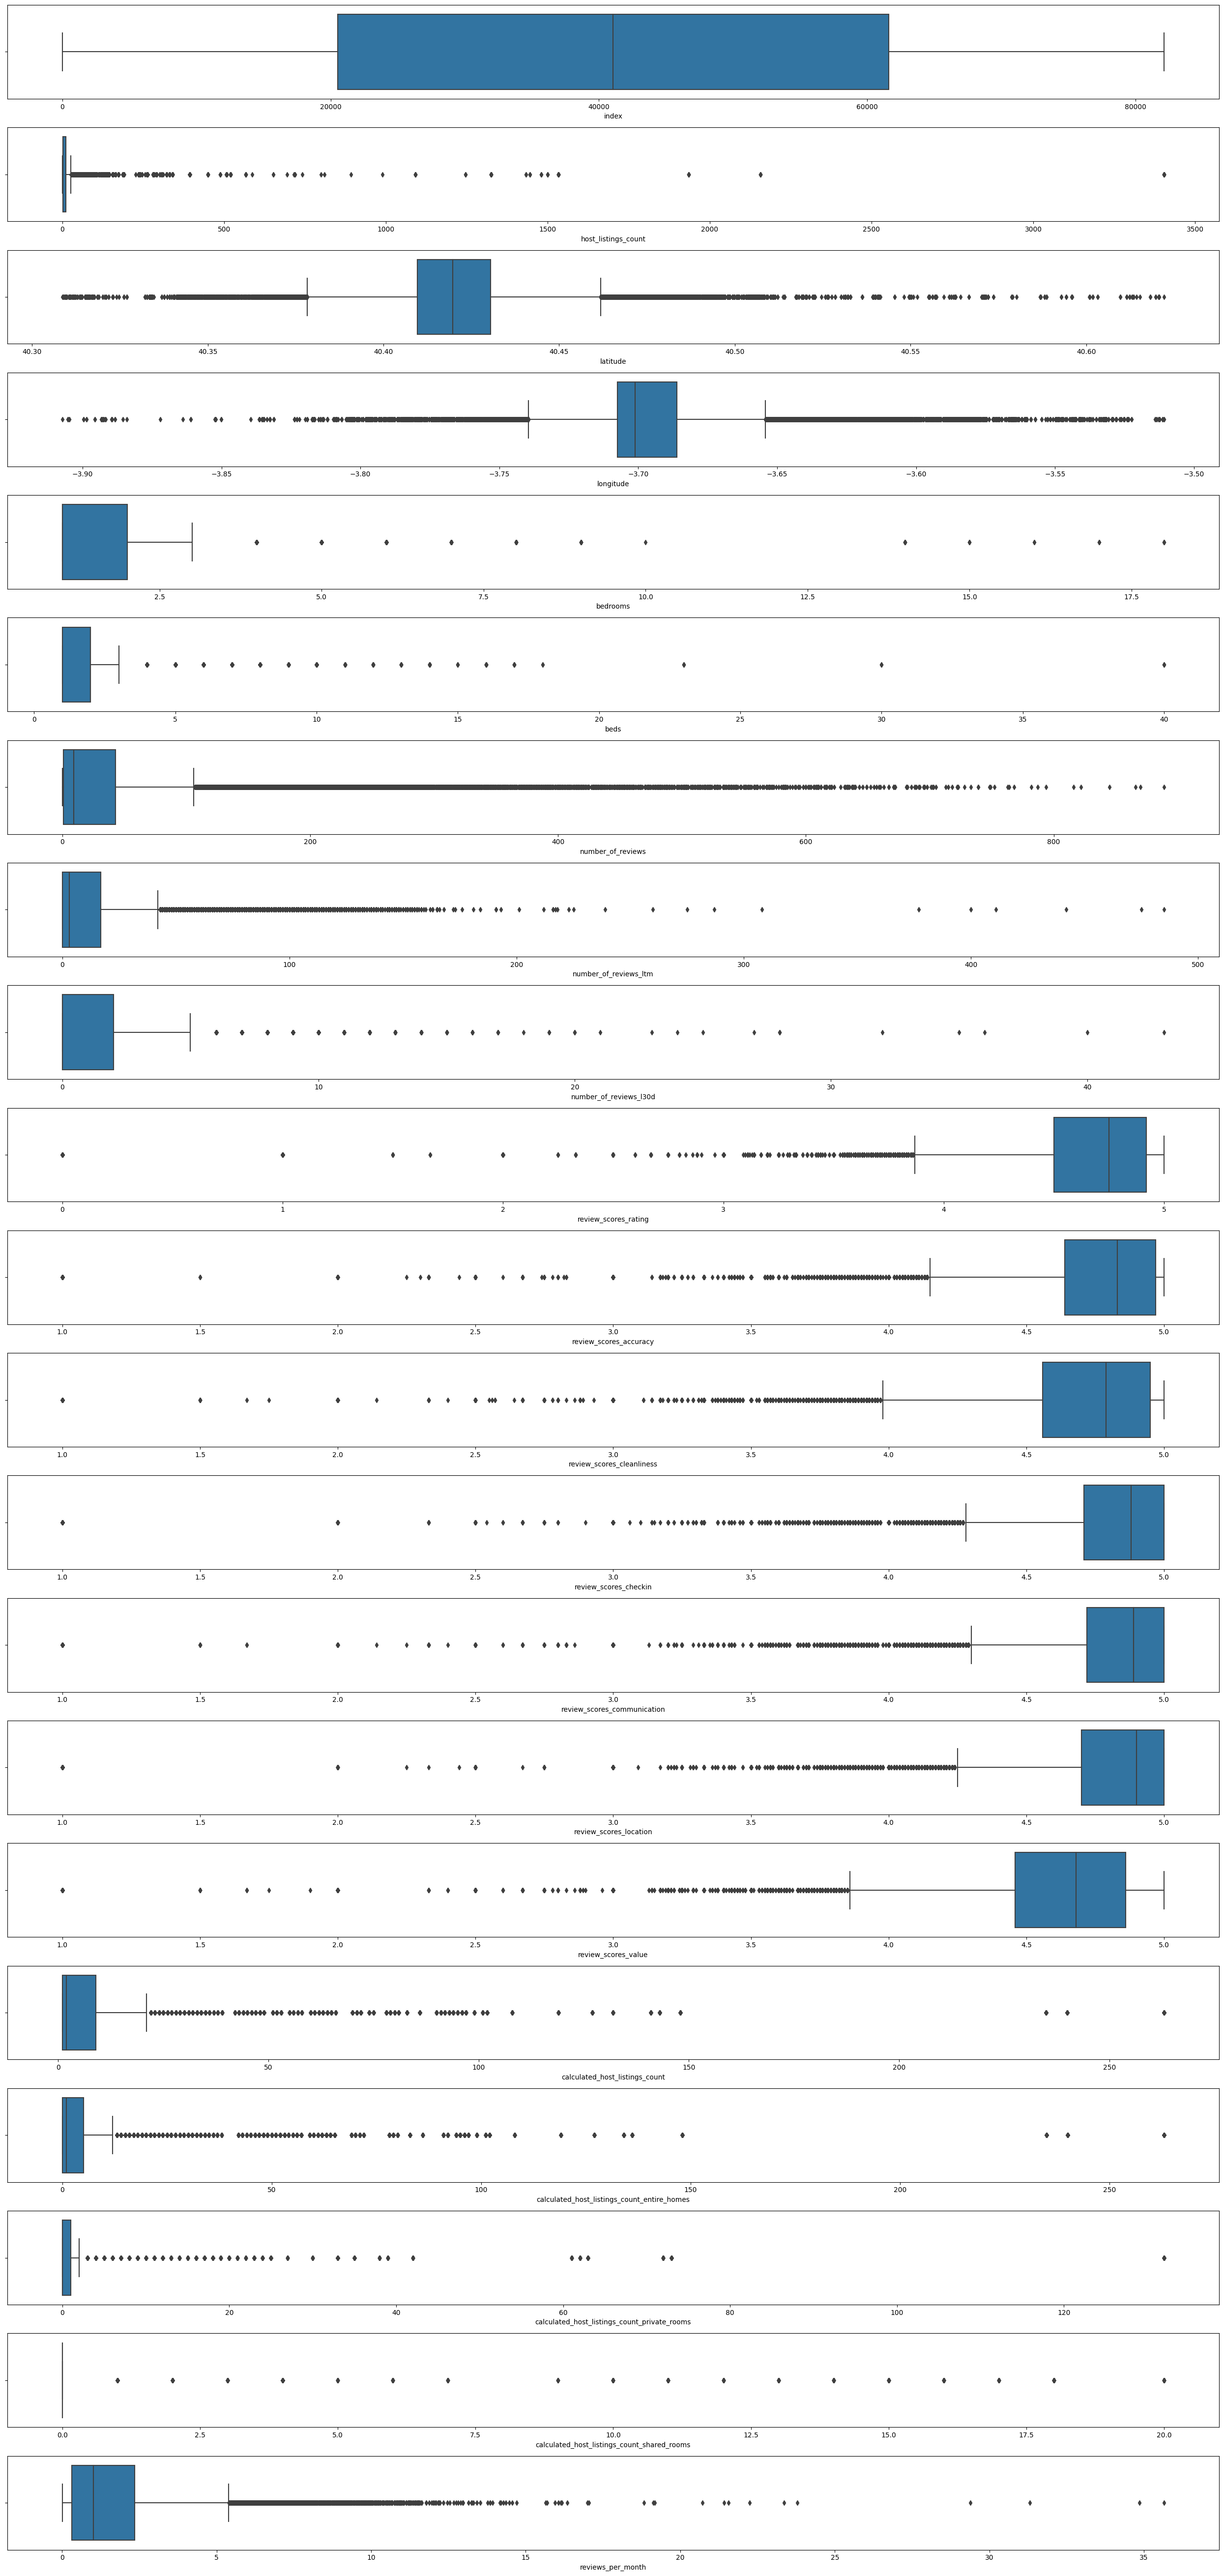

In [12]:
sch.chart_boxplot(df.reset_index())

# export

In [ ]:
sc.exportFiles(gdf, df, 'airbnb')